In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

# Import our selective classification modules
from selective_classification import apply_selective_classification_to_imagenet

!pip install -U --no-cache-dir gdown --pre

^C
ERROR: Operation cancelled by user


In [2]:
# Load cached data
if not os.path.exists('../data'):
    os.system('gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz')
    os.system('tar -xf ../data.tar.gz -C ../')
    os.system('rm ../data.tar.gz')
if not os.path.exists('../data/imagenet/human_readable_labels.json'):
    !wget -nv -O ../data/imagenet/human_readable_labels.json -L https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json

data = np.load('../data/imagenet/imagenet-resnet152.npz')
example_paths = os.listdir('../data/imagenet/examples')
smx = data['smx']
labels = data['labels'].astype(int)

In [3]:
# Problem setup
n = 1000  # number of calibration points
alpha = 0.1  # target risk level (1-alpha is the desired selective accuracy)

# LTT method parameters
delta = 0.1
thetas = np.linspace(0, 1, 5000)

In [4]:
# Split the softmax scores into calibration and validation sets
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx,:], smx[~idx,:]
cal_labels, val_labels = labels[idx], labels[~idx]
# Yhat, Phat
cal_yhats = np.argmax(cal_smx,axis=1); val_yhats = np.argmax(val_smx,axis=1);
cal_phats = cal_smx.max(axis=1); val_phats = np.max(val_smx,axis=1);

### Three-Way Comparison: CRC-C vs CRC vs LTT

We compare the conservative CRC to both standard CRC and LTT.

- **CRC-C**: Conservative Conformal Risk Control
- **CRC**: Standard Conformal Risk Control
- **LTT**: Learn Then Test

In [9]:
import time

# CRC-C runtime (INCLUDING stability estimation)
print("CRC-C")
time_start_crc_c = time.time()

results_conservative = apply_selective_classification_to_imagenet(
    cal_smx, cal_labels, val_smx, val_labels, 
    alpha=alpha, stability_estimator='K',
    verbose=False
)

time_crc_c = time.time() - time_start_crc_c  # Total time including beta estimation

# Also run standard CRC
print(f"CRC (time = {time_crc_c})")
time_start_crc = time.time()
results_standard = apply_selective_classification_to_imagenet(
    cal_smx, cal_labels, val_smx, val_labels, 
    alpha=alpha,
    verbose=False
)

time_crc = time.time() - time_start_crc  # Total time including beta estimation

# Also run LTT
print(f"LTT (time={time_crc})")

time_start_ltt = time.time()
results_ltt = apply_selective_classification_to_imagenet(
    cal_smx, cal_labels, val_smx, val_labels, 
    alpha=alpha, LTT=True, delta=delta,
    verbose=False
)
time_ltt = time.time() - time_start_ltt

print(f"Complete (time={time_ltt})")

# Extract results
lhat_conservative = results_conservative['theta_hat']
empirical_selective_accuracy_conservative = results_conservative['empirical_selective_accuracy']
prediction_rate_conservative = results_conservative['prediction_rate']

lhat_standard = results_standard['theta_hat']
empirical_selective_accuracy_standard = results_standard['empirical_selective_accuracy']
prediction_rate_standard = results_standard['prediction_rate']

lhat_ltt = results_ltt['theta_hat']
empirical_selective_accuracy_ltt = results_ltt['empirical_selective_accuracy']
prediction_rate_ltt = results_ltt['prediction_rate']

# Three-way comparison with runtime
print("\n" + "="*85)
print("THREE-WAY COMPARISON: CRC-C vs CRC vs LTT")
print("="*85)
print(f"{'Metric':<40} {'CRC-C':<15} {'CRC':<15} {'LTT':<15}")
print("-"*85)
print(f"{'Threshold':<40} {lhat_conservative:<15.4f} {lhat_standard:<15.4f} {lhat_ltt:<15.4f}")
print(f"{'Selective accuracy':<40} {empirical_selective_accuracy_conservative:<15.4f} {empirical_selective_accuracy_standard:<15.4f} {empirical_selective_accuracy_ltt:<15.4f}")
print(f"{'Prediction rate':<40} {prediction_rate_conservative:<15.4f} {prediction_rate_standard:<15.4f} {prediction_rate_ltt:<15.4f}")
print(f"{'Runtime (seconds)':<40} {time_crc_c:<15.4f} {time_crc:<15.4f} {time_ltt:<15.4f}")
print(f"{'Speedup vs LTT':<40} {f'{time_ltt/time_crc_c:.1f}x faster':<15} {f'{time_ltt/time_crc:.1f}x faster':<15} {'—':<15}")
print("="*85)

CRC-C
CRC (time = 47.4882550239563)
LTT (time=0.02157902717590332)
Complete (time=0.7279260158538818)

THREE-WAY COMPARISON: CRC-C vs CRC vs LTT
Metric                                   CRC-C           CRC             LTT            
-------------------------------------------------------------------------------------
Threshold                                0.7177          0.7049          1.0000         
Selective accuracy                       0.9032          0.8996          1.0000         
Prediction rate                          0.7476          0.7556          0.0064         
Runtime (seconds)                        47.4883         0.0216          0.7279         
Speedup vs LTT                           0.0x faster     33.7x faster    —              


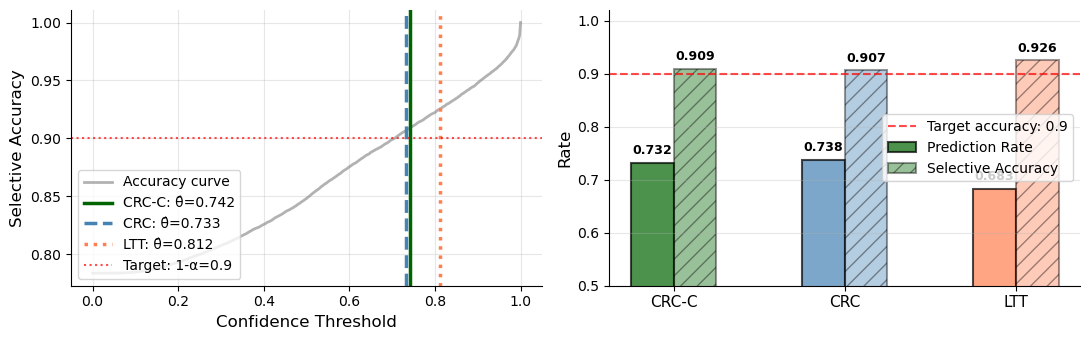

In [7]:
# Visual comparison of three methods
fig, axes = plt.subplots(1, 2, figsize=(11, 3.5))

# Compute accuracy curve
thetas_viz = np.linspace(0, 1, 500)
accuracy_curve = []

for lam in thetas_viz:
    sel = val_phats >= lam
    if sel.sum() > 0:
        accuracy_curve.append((val_yhats[sel] == val_labels[sel]).mean())
    else:
        accuracy_curve.append(0)

# Plot 1: Threshold comparison
ax = axes[0]
ax.plot(thetas_viz, accuracy_curve, label='Accuracy curve', linewidth=2, color='gray', alpha=0.6)
ax.axvline(x=lhat_conservative, linewidth=2.5, linestyle='-', label=f'CRC-C: θ̂={lhat_conservative:.3f}', color='darkgreen')
ax.axvline(x=lhat_standard, linewidth=2.5, linestyle='--', label=f'CRC: θ̂={lhat_standard:.3f}', color='steelblue')
ax.axvline(x=lhat_ltt, linewidth=2.5, linestyle=':', label=f'LTT: θ̂={lhat_ltt:.3f}', color='coral')
ax.axhline(y=1-alpha, linewidth=1.5, linestyle='dotted', label=f'Target: 1-α={1-alpha}', color='red', alpha=0.7)
ax.set_xlabel('Confidence Threshold', fontsize=12)
ax.set_ylabel('Selective Accuracy', fontsize=12)
ax.legend(fontsize=10, loc='lower left')
ax.grid(True, alpha=0.3)
sns.despine(ax=ax)

# Plot 2: Performance bars
ax = axes[1]
width = 0.25
x_pos = np.arange(3)
pred_rates = [prediction_rate_conservative, prediction_rate_standard, prediction_rate_ltt]
accuracies = [empirical_selective_accuracy_conservative, empirical_selective_accuracy_standard, empirical_selective_accuracy_ltt]
colors_bars = ['darkgreen', 'steelblue', 'coral']
labels_bars = ['CRC-C', 'CRC', 'LTT']

bars1 = ax.bar(x_pos - width/2, pred_rates, width, label='Prediction Rate', 
               color=colors_bars, alpha=0.7, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x_pos + width/2, accuracies, width, label='Selective Accuracy',
               color=colors_bars, alpha=0.4, edgecolor='black', linewidth=1.5, hatch='//')

for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    ax.text(bar1.get_x() + bar1.get_width()/2., height1 + 0.01,
            f'{height1:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    ax.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.01,
            f'{height2:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.axhline(y=1-alpha, linewidth=1.5, linestyle='--', color='red', alpha=0.7, 
           label=f'Target accuracy: {1-alpha:.1f}')
ax.set_ylabel('Rate', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels_bars, fontsize=11)
ax.legend(loc='center right', fontsize=10)
ax.set_ylim([0.5, 1.02])
ax.grid(True, alpha=0.3, axis='y')
sns.despine(ax=ax)

plt.tight_layout()
os.makedirs('./plots', exist_ok=True)
plt.savefig('./plots/conservative-crc-comparison.pdf', dpi=60)
plt.show()


### 100-Replicate Experiment: Distribution Comparison

To thoroughly compare the three methods, we run 100 replicates with different random calibration/validation splits.


In [10]:
print("Running 100-replicate experiment...")
print("This will take several minutes...\n")

n_replicates = 10
results_experiment = {
    'crc_c_accuracy': [],
    'crc_c_pred_rate': [],
    'crc_c_threshold': [],
    'crc_accuracy': [],
    'crc_pred_rate': [],
    'crc_threshold': [],
    'ltt_accuracy': [],
    'ltt_pred_rate': [],
    'ltt_threshold': []
}

for rep in range(n_replicates):
    if (rep + 1) % 20 == 0:
        print(f"  Completed {rep + 1}/{n_replicates} replicates...")
    
    # Random split
    idx_rep = np.array([1] * n + [0] * (smx.shape[0] - n)) > 0
    np.random.shuffle(idx_rep)
    
    cal_smx_rep = smx[idx_rep, :]
    val_smx_rep = smx[~idx_rep, :]
    cal_labels_rep = labels[idx_rep]
    val_labels_rep = labels[~idx_rep]
    
    
    # CRC-C METHOD
    res_crc_c = apply_selective_classification_to_imagenet(
        cal_smx_rep, cal_labels_rep, val_smx_rep, val_labels_rep,
        alpha=alpha, stability_estimator='K', verbose=False
    )
    results_experiment['crc_c_accuracy'].append(res_crc_c['empirical_selective_accuracy'])
    results_experiment['crc_c_pred_rate'].append(res_crc_c['prediction_rate'])
    results_experiment['crc_c_threshold'].append(res_crc_c['theta_hat'])
    
    # CRC METHOD (standard)
    res_crc = apply_selective_classification_to_imagenet(
        cal_smx_rep, cal_labels_rep, val_smx_rep, val_labels_rep,
        alpha=alpha, verbose=False
    )
    results_experiment['crc_accuracy'].append(res_crc['empirical_selective_accuracy'])
    results_experiment['crc_pred_rate'].append(res_crc['prediction_rate'])
    results_experiment['crc_threshold'].append(res_crc['theta_hat'])
    
    # LTT METHOD
    res_ltt = apply_selective_classification_to_imagenet(
        cal_smx_rep, cal_labels_rep, val_smx_rep, val_labels_rep,
        alpha=alpha, LTT=True, verbose=False
    )
    results_experiment['ltt_accuracy'].append(res_ltt['empirical_selective_accuracy'])
    results_experiment['ltt_pred_rate'].append(res_ltt['prediction_rate'])
    results_experiment['ltt_threshold'].append(res_ltt['theta_hat'])

# Convert to arrays
for key in results_experiment:
    results_experiment[key] = np.array(results_experiment[key])

print(f"✓ Completed all {n_replicates} replicates!\n")

# Summary statistics
print("=" * 85)
print("100-REPLICATE EXPERIMENT RESULTS")
print("=" * 85)
print(f"{'Metric':<35} {'CRC-C':<16} {'CRC':<16} {'LTT':<16}")
print("-" * 85)
print(f"{'Mean Selective Accuracy':<35} {results_experiment['crc_c_accuracy'].mean():<16.4f} {results_experiment['crc_accuracy'].mean():<16.4f} {results_experiment['ltt_accuracy'].mean():<16.4f}")
print(f"{'Std Selective Accuracy':<35} {results_experiment['crc_c_accuracy'].std():<16.4f} {results_experiment['crc_accuracy'].std():<16.4f} {results_experiment['ltt_accuracy'].std():<16.4f}")
print(f"{'Mean Prediction Rate':<35} {results_experiment['crc_c_pred_rate'].mean():<16.4f} {results_experiment['crc_pred_rate'].mean():<16.4f} {results_experiment['ltt_pred_rate'].mean():<16.4f}")
print(f"{'Std Prediction Rate':<35} {results_experiment['crc_c_pred_rate'].std():<16.4f} {results_experiment['crc_pred_rate'].std():<16.4f} {results_experiment['ltt_pred_rate'].std():<16.4f}")
print(f"{'Mean Threshold':<35} {results_experiment['crc_c_threshold'].mean():<16.4f} {results_experiment['crc_threshold'].mean():<16.4f} {results_experiment['ltt_threshold'].mean():<16.4f}")
print(f"{'Std Threshold':<35} {results_experiment['crc_c_threshold'].std():<16.4f} {results_experiment['crc_threshold'].std():<16.4f} {results_experiment['ltt_threshold'].std():<16.4f}")
print("-" * 85)
print(f"{'Accuracy violations (> α)':<35} {(results_experiment['crc_c_accuracy'] < 1-alpha).sum():<16} {(results_experiment['crc_accuracy'] < 1-alpha).sum():<16} {(results_experiment['ltt_accuracy'] < 1-alpha).sum():<16}")
print(f"{'Violation rate':<35} {100*(results_experiment['crc_c_accuracy'] < 1-alpha).mean():<15.1f}% {100*(results_experiment['crc_accuracy'] < 1-alpha).mean():<15.1f}% {100*(results_experiment['ltt_accuracy'] < 1-alpha).mean():<15.1f}%")
print("=" * 85)

Running 100-replicate experiment...
This will take several minutes...

✓ Completed all 10 replicates!

100-REPLICATE EXPERIMENT RESULTS
Metric                              CRC-C            CRC              LTT             
-------------------------------------------------------------------------------------
Mean Selective Accuracy             0.9072           0.9024           0.9997          
Std Selective Accuracy              0.0077           0.0090           0.0006          
Mean Prediction Rate                0.7362           0.7490           0.0145          
Std Prediction Rate                 0.0205           0.0234           0.0036          
Mean Threshold                      0.7346           0.7144           1.0000          
Std Threshold                       0.0312           0.0372           0.0000          
-------------------------------------------------------------------------------------
Accuracy violations (> α)           1                3                0            

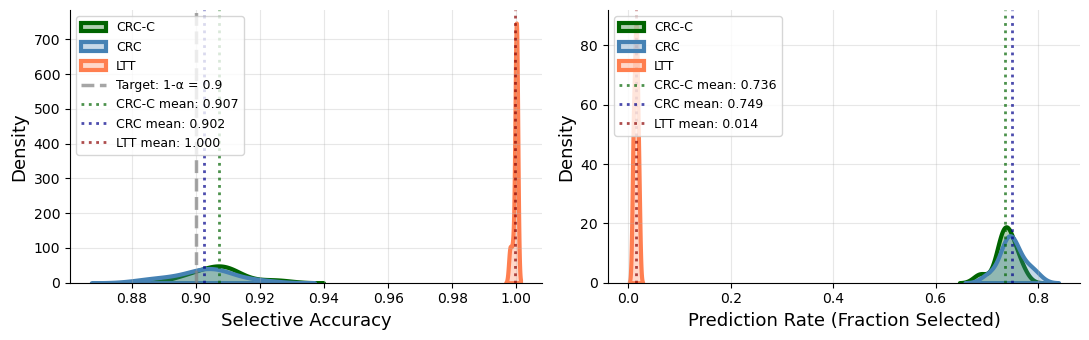


STATISTICAL ANALYSIS

📊 Selective Accuracy:
  • CRC-C: 0.9072 ± 0.0077
  • CRC:   0.9024 ± 0.0090
  • LTT:   0.9997 ± 0.0006
  • Violations (accuracy < 1-α):
    - CRC-C: 1/10 (10.0%)
    - CRC:   3/10 (30.0%)
    - LTT:   0/10 (0.0%)

📊 Prediction Rate:
  • CRC-C: 0.7362 ± 0.0205
  • CRC:   0.7490 ± 0.0234
  • LTT:   0.0145 ± 0.0036
  • CRC makes predictions on 1.7% more examples than CRC-C on average


In [11]:
# KDE plots comparing distributions
fig, axes = plt.subplots(1, 2, figsize=(11, 3.5))

# Plot 1: Selective Accuracy Distribution
ax = axes[0]
sns.kdeplot(results_experiment['crc_c_accuracy'], ax=ax, label='CRC-C', 
            color='darkgreen', linewidth=3, fill=True, alpha=0.3)
sns.kdeplot(results_experiment['crc_accuracy'], ax=ax, label='CRC', 
            color='steelblue', linewidth=3, fill=True, alpha=0.3)
sns.kdeplot(results_experiment['ltt_accuracy'], ax=ax, label='LTT', 
            color='coral', linewidth=3, fill=True, alpha=0.3)
ax.axvline(x=1-alpha, linewidth=2.5, linestyle='--', color='gray', 
           label=f'Target: 1-α = {1-alpha}', alpha=0.7)

# Add mean lines
ax.axvline(x=results_experiment['crc_c_accuracy'].mean(), linewidth=2, 
           linestyle=':', color='darkgreen', alpha=0.7, 
           label=f"CRC-C mean: {results_experiment['crc_c_accuracy'].mean():.3f}")
ax.axvline(x=results_experiment['crc_accuracy'].mean(), linewidth=2, 
           linestyle=':', color='darkblue', alpha=0.7,
           label=f"CRC mean: {results_experiment['crc_accuracy'].mean():.3f}")
ax.axvline(x=results_experiment['ltt_accuracy'].mean(), linewidth=2, 
           linestyle=':', color='darkred', alpha=0.7,
           label=f"LTT mean: {results_experiment['ltt_accuracy'].mean():.3f}")

ax.set_xlabel('Selective Accuracy', fontsize=13)
ax.set_ylabel('Density', fontsize=13)
ax.legend(fontsize=9, loc='upper left')
ax.grid(True, alpha=0.3)
sns.despine(ax=ax)

# Plot 2: Prediction Rate Distribution
ax = axes[1]
sns.kdeplot(results_experiment['crc_c_pred_rate'], ax=ax, label='CRC-C', 
            color='darkgreen', linewidth=3, fill=True, alpha=0.3)
sns.kdeplot(results_experiment['crc_pred_rate'], ax=ax, label='CRC', 
            color='steelblue', linewidth=3, fill=True, alpha=0.3)
sns.kdeplot(results_experiment['ltt_pred_rate'], ax=ax, label='LTT', 
            color='coral', linewidth=3, fill=True, alpha=0.3)

# Add mean lines
ax.axvline(x=results_experiment['crc_c_pred_rate'].mean(), linewidth=2, 
           linestyle=':', color='darkgreen', alpha=0.7,
           label=f"CRC-C mean: {results_experiment['crc_c_pred_rate'].mean():.3f}")
ax.axvline(x=results_experiment['crc_pred_rate'].mean(), linewidth=2, 
           linestyle=':', color='darkblue', alpha=0.7,
           label=f"CRC mean: {results_experiment['crc_pred_rate'].mean():.3f}")
ax.axvline(x=results_experiment['ltt_pred_rate'].mean(), linewidth=2, 
           linestyle=':', color='darkred', alpha=0.7,
           label=f"LTT mean: {results_experiment['ltt_pred_rate'].mean():.3f}")

ax.set_xlabel('Prediction Rate (Fraction Selected)', fontsize=13)
ax.set_ylabel('Density', fontsize=13)
ax.legend(fontsize=9, loc='upper left')
ax.grid(True, alpha=0.3)
sns.despine(ax=ax)

plt.tight_layout()
plt.savefig('./plots/conservative-crc-kde-distributions.pdf', dpi=60)
plt.show()

# Statistical comparison
print("\n" + "=" * 85)
print("STATISTICAL ANALYSIS")
print("=" * 85)

print(f"\n📊 Selective Accuracy:")
print(f"  • CRC-C: {results_experiment['crc_c_accuracy'].mean():.4f} ± {results_experiment['crc_c_accuracy'].std():.4f}")
print(f"  • CRC:   {results_experiment['crc_accuracy'].mean():.4f} ± {results_experiment['crc_accuracy'].std():.4f}")
print(f"  • LTT:   {results_experiment['ltt_accuracy'].mean():.4f} ± {results_experiment['ltt_accuracy'].std():.4f}")

acc_below_target_crc_c = (results_experiment['crc_c_accuracy'] < 1-alpha).sum()
acc_below_target_crc = (results_experiment['crc_accuracy'] < 1-alpha).sum()
acc_below_target_ltt = (results_experiment['ltt_accuracy'] < 1-alpha).sum()
print(f"  • Violations (accuracy < 1-α):")
print(f"    - CRC-C: {acc_below_target_crc_c}/{n_replicates} ({100*acc_below_target_crc_c/n_replicates:.1f}%)")
print(f"    - CRC:   {acc_below_target_crc}/{n_replicates} ({100*acc_below_target_crc/n_replicates:.1f}%)")
print(f"    - LTT:   {acc_below_target_ltt}/{n_replicates} ({100*acc_below_target_ltt/n_replicates:.1f}%)")

print(f"\n📊 Prediction Rate:")
print(f"  • CRC-C: {results_experiment['crc_c_pred_rate'].mean():.4f} ± {results_experiment['crc_c_pred_rate'].std():.4f}")
print(f"  • CRC:   {results_experiment['crc_pred_rate'].mean():.4f} ± {results_experiment['crc_pred_rate'].std():.4f}")
print(f"  • LTT:   {results_experiment['ltt_pred_rate'].mean():.4f} ± {results_experiment['ltt_pred_rate'].std():.4f}")

if results_experiment['crc_pred_rate'].mean() > results_experiment['crc_c_pred_rate'].mean():
    diff_pct = 100 * (results_experiment['crc_pred_rate'].mean() - results_experiment['crc_c_pred_rate'].mean()) / results_experiment['crc_c_pred_rate'].mean()
    print(f"  • CRC makes predictions on {diff_pct:.1f}% more examples than CRC-C on average")

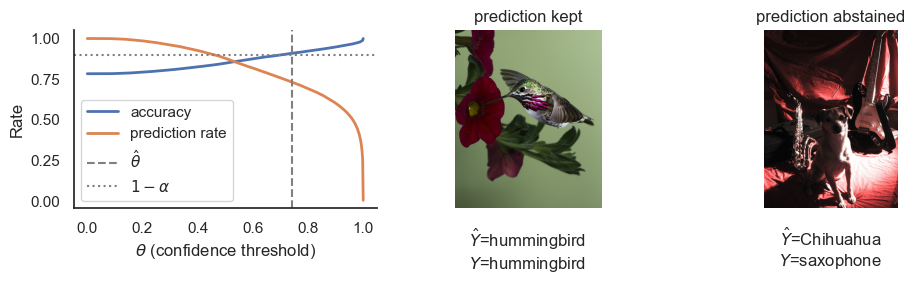

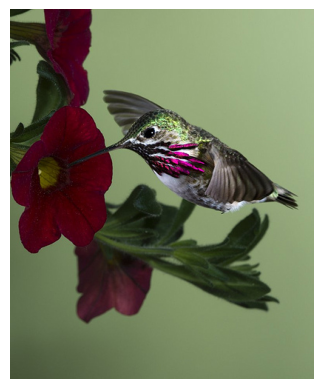

Prediction: hummingbird | Label: hummingbird | Abstained: False


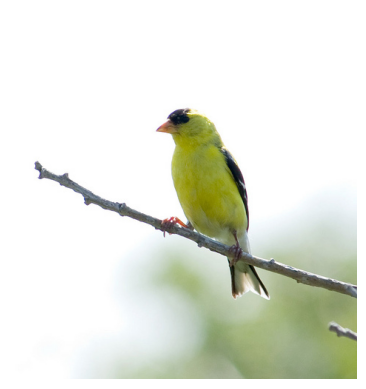

Prediction: goldfinch | Label: goldfinch | Abstained: False


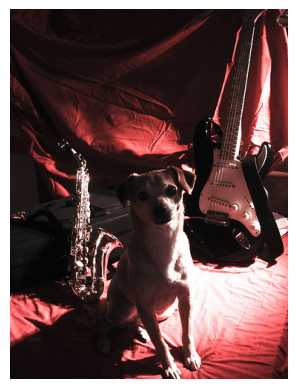

Prediction: Chihuahua | Label: saxophone | Abstained: True


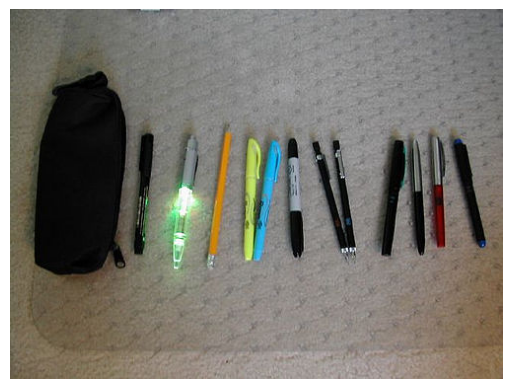

Prediction: eraser | Label: pencil case | Abstained: True


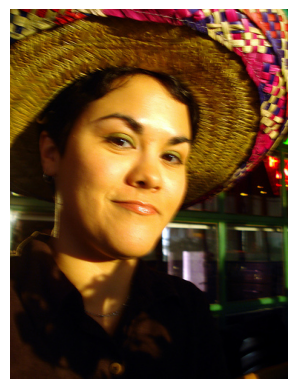

Prediction: sombrero | Label: sombrero | Abstained: False


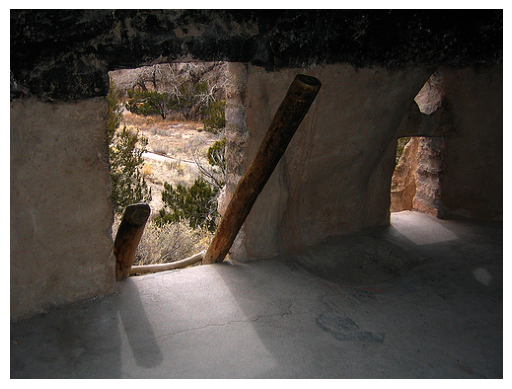

Prediction: cliff dwelling | Label: cliff dwelling | Abstained: True


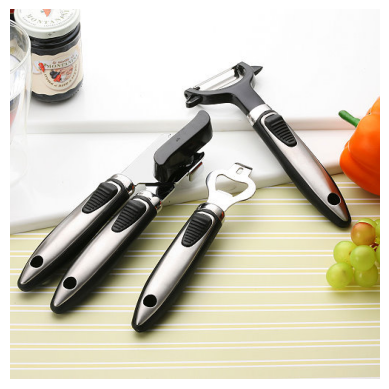

Prediction: can opener | Label: can opener | Abstained: False


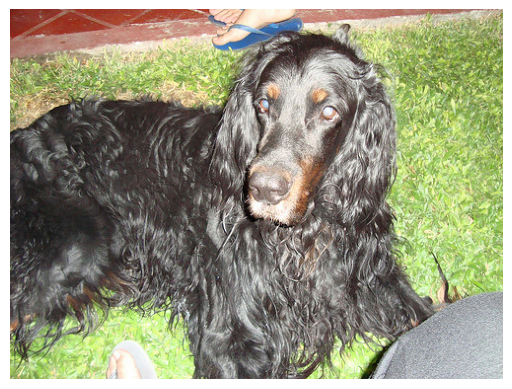

Prediction: Gordon Setter | Label: Gordon Setter | Abstained: False


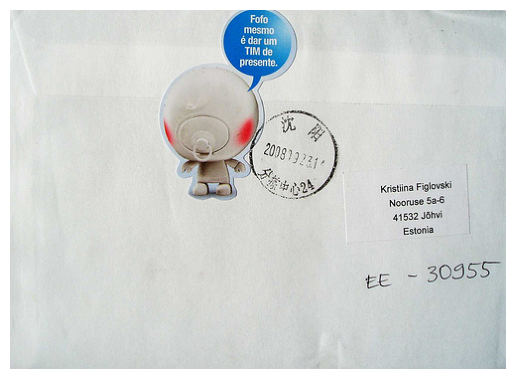

Prediction: envelope | Label: envelope | Abstained: False


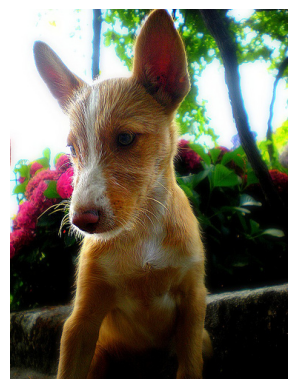

Prediction: Ibizan Hound | Label: Ibizan Hound | Abstained: False


In [29]:
# Get some examples
with open('../data/imagenet/human_readable_labels.json') as f:
    label_strings = np.array(json.load(f))

example_paths = os.listdir('../data/imagenet/examples')
_imgs = []
_keeps = []
_yhats = []
_labels = []
for i in range(10):
    rand_path = np.random.choice(example_paths)
    _imgs += [imread('../data/imagenet/examples/' + rand_path)]
    img_index = int(rand_path.split('.')[0])
    _keeps += [np.max(smx[img_index]) >= lhat_conservative]
    _yhats += [label_strings[np.argmax(smx[img_index])]]
    _labels += [label_strings[labels[img_index]]]        
_keeps = np.array(_keeps)
_yhats = np.array(_yhats)
_labels = np.array(_labels)

# Plot numerics and selected examples
sns.set(style='white')

# Compute curves for visualization
thetas_viz = np.linspace(0, 1, 500)
accuracy_curve = []
prediction_rate_curve = []

for lam in thetas_viz:
    selected = val_phats >= lam
    if selected.sum() > 0:
        accuracy_curve.append((val_yhats[selected] == val_labels[selected]).mean())
        prediction_rate_curve.append(selected.mean())
    else:
        accuracy_curve.append(0)
        prediction_rate_curve.append(0)

fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# Plot 1: Accuracy and prediction rate vs threshold
axs[0].plot(thetas_viz, accuracy_curve, label='accuracy', linewidth=2)
axs[0].plot(thetas_viz, prediction_rate_curve, label='prediction rate', linewidth=2)
axs[0].axvline(x=lhat_conservative, linewidth=1.5, linestyle='--', label=r'$\hat{\theta}$', color='gray')
axs[0].axhline(y=1-alpha, linewidth=1.5, linestyle='dotted', label=r'$1-\alpha$', color='gray')
sns.despine(ax=axs[0], top=True, right=True)
axs[0].legend(loc='lower left')
axs[0].set_xlabel(r'$\theta$ (confidence threshold)')
axs[0].set_ylabel('Rate')

# Plot 2: Example where prediction is kept
true_nonabstention_idx = np.argmax((_yhats == _labels) & (_keeps))
axs[1].set_title('prediction kept')
axs[1].imshow(_imgs[true_nonabstention_idx])
axs[1].set_xlabel(r'$\hat{Y}$' + f'={_yhats[true_nonabstention_idx]}\n' + r'$Y$' + f'={_labels[true_nonabstention_idx]}')
axs[1].set_yticklabels([])
axs[1].set_xticklabels([])
sns.despine(ax=axs[1], top=True, right=True, left=True, bottom=True)

# Plot 3: Example where prediction is abstained
true_abstention_idx = np.argmax((_yhats != _labels) & (~_keeps))
axs[2].set_title('prediction abstained')
axs[2].imshow(_imgs[true_abstention_idx])
axs[2].set_xlabel(r'$\hat{Y}$' + f'={_yhats[true_abstention_idx]}\n' + r'$Y$' + f'={_labels[true_abstention_idx]}')
axs[2].set_yticklabels([])
axs[2].set_xticklabels([])
sns.despine(ax=axs[2], top=True, right=True, left=True, bottom=True)

plt.tight_layout()
plt.savefig('./plots/selective-classification-results.pdf', dpi=60, bbox_inches='tight')
plt.show()
    
# Plot more examples
for i in range(len(_imgs)):
    plt.figure()
    plt.imshow(_imgs[i])
    plt.axis('off')
    plt.show()
    print(f"Prediction: {_yhats[i]} | Label: {_labels[i]} | Abstained: {~_keeps[i]}")